In [1]:
# Translation of script_nd_sphere.m (lines 1-68) to Python
import numpy as np
from scipy.linalg import svd

# Set random seed for reproducibility (optional)
np.random.seed(0)

# Sample 500 points from a 3D Gaussian (as in the MATLAB code)
n = 500
d = 3
lambda_ = 1
u = np.random.normal(0, 1, (n, d))
u[:, 0] = lambda_ * u[:, 0]
u_norm = np.linalg.norm(u, axis=1, keepdims=True)
r = np.sqrt(np.random.rand(n, 1)) * 1/100 + 99/100
u_trans = u / u_norm

# X_tar = r * u_trans (element-wise multiplication)
X_tar = r * u_trans
# n = X_tar.shape[0] (already n=500, but keep for consistency)
n = X_tar.shape[0]

# Form the anisotropic graph Laplacian
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
epsilon = 0.5 * np.median(H) / np.log(n + 1)
# Kernel function
def ker(X):
    sq_tar = np.sum(X ** 2, axis=1)
    return np.exp(-(sq_tar[:, None] + sq_tar[None, :] - 2 * (X @ X.T)) / (2 * epsilon))

data_kernel = ker(X_tar)
p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()

# Normalize kernel
data_kernel_norm = data_kernel / p_x[:, None] / p_y[None, :]
D_y = np.sum(data_kernel_norm, axis=0)

rw_kernel = 0.5 * (data_kernel_norm / D_y + (data_kernel_norm / D_y).T)
# SVD decomposition
phi, s, _ = svd(rw_kernel)
lambda_ns = s
lambda_ = -lambda_ns + 1
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1 / lambda_[1:]
inv_lambda = inv_lambda * epsilon
inv_K = phi @ np.diag(inv_lambda) @ phi.T

# Regularization and tolerance
# (MATLAB: tol = 1e-6; lambda_ns(lambda_ns<tol) = 0; ...)
tol = 1e-6
lambda_ns_mod = np.copy(lambda_ns)
lambda_ns_mod[lambda_ns_mod < tol] = 0
below_tol = np.sum(lambda_ns < tol)
above_tol = n - below_tol
reg = 0.001
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + reg)
# The rest remain zero
inv_K_ns = phi @ np.diag(lambda_ns_inv) @ phi.T


In [2]:
# Import the translated kernel and gradient functions
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

In [3]:
# Translation of script_nd_sphere.m lines 75-139 to Python
# Assumes grad_ker1 and K_tar_eval are already implemented and imported

iter = 1000
h = 5
m = 700

# Initialize particles
u = np.random.normal(0, 1, (m, d))
u_norm = np.linalg.norm(u, axis=1, keepdims=True)
r = np.sqrt(np.random.rand(m, 1)) * 1/100 + 99/100
u_trans = u / u_norm
x_init = r * u_trans
x_init = x_init[x_init[:, 1] > 0.7, :]
m = x_init.shape[0]
x_t = np.zeros((m, d, iter))
x_t[:, :, 0] = x_init

# Precompute quantities
p_tar = np.sum(data_kernel, axis=0)
D = np.sum(data_kernel / np.sqrt(p_tar) / np.sqrt(p_tar)[:, None], axis=1)

# inv_K_ns_s_ns, lambda_s_s_ns, lambda_ns_s_ns
inv_K_ns_s_ns = phi @ np.diag(lambda_ns_inv * inv_lambda * lambda_ns_inv) @ phi.T
lambda_s_s_ns = inv_lambda * inv_lambda * lambda_ns_inv
lambda_s_s_ns = lambda_s_s_ns[:above_tol]
lambda_ns_s_ns = lambda_ns_inv * inv_lambda * lambda_ns_inv
lambda_ns_s_ns = lambda_ns_s_ns[:above_tol]

sum_x = np.zeros((m, d))
for t in range(iter - 1):
    # grad_ker1 and K_tar_eval are assumed to be implemented elsewhere
    grad_matrix = grad_ker1(x_t[:, :, t], X_tar, p_tar, sq_tar, D, epsilon)
    cross_matrix = K_tar_eval(X_tar, x_t[:, :, t], p_tar, sq_tar, D, epsilon)
    for i in range(d):
        # sum_x[:, i] = np.sum(grad_matrix[:, :, i] @ phi[:, :above_tol] @ np.diag(lambda_ns_s_ns) @ phi[:, :above_tol].T @ cross_matrix, axis=1)
        sum_x[:, i] = np.sum(grad_matrix[:, :, i] @ phi[:, :above_tol] @ np.diag(lambda_ns_s_ns) @ phi[:, :above_tol].T @ cross_matrix, axis=1)
        # Optionally normalize: sum_x[:, i] /= np.linalg.norm(sum_x[:, i])
    x_t[:, :, t + 1] = x_t[:, :, t] - h / m * sum_x


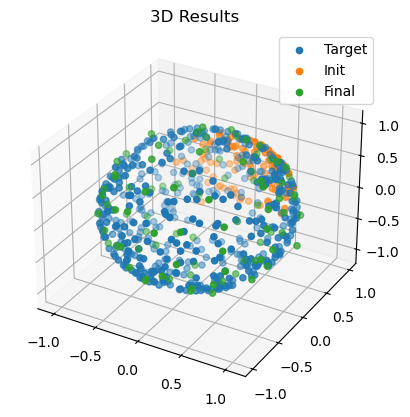

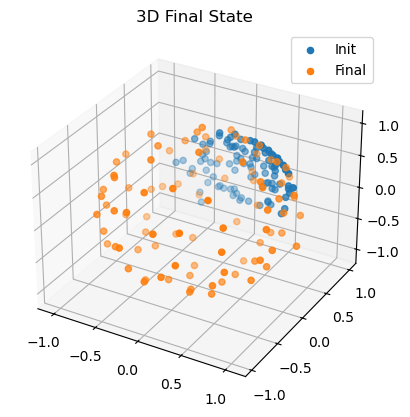

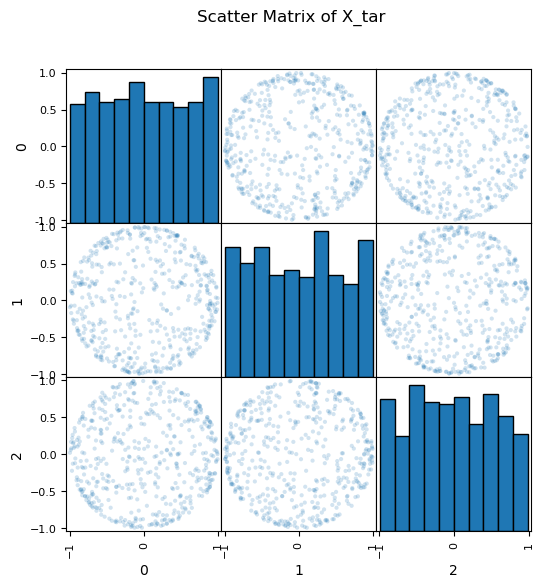

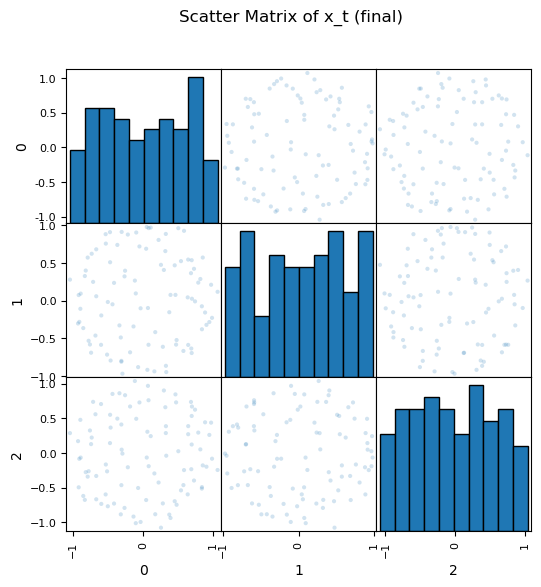

In [4]:
# Translation of script_nd_sphere.m lines 144-168 to Python
import pandas as pd
import matplotlib.pyplot as plt


# Plotting results
if d == 2:
    plt.figure()
    plt.plot(X_tar[:, 0], X_tar[:, 1], 'o', label='Target')
    plt.plot(x_t[:, 0, 0], x_t[:, 1, 0], 'o', label='Init')
    plt.plot(x_t[:, 0, -1], x_t[:, 1, -1], 'o', label='Final')
    plt.legend()
    plt.title('2D Results')
    plt.show()
else:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], label='Target')
    ax.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], label='Init')
    ax.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], label='Final')
    ax.legend()
    plt.title('3D Results')
    plt.show()
    # Additional plot for final state only
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], label='Init')
    ax2.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], label='Final')
    ax2.legend()
    plt.title('3D Final State')
    plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(X_tar),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle('Scatter Matrix of X_tar')
plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(x_t[:, :, -1]),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle('Scatter Matrix of x_t (final)')
plt.show()

In [5]:
# Quick check: print epsilon used in DMPS
print('DMPS epsilon =', float(epsilon))

DMPS epsilon = 0.15989518563138197
